In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import mcspace.vis_tools as vis
import matplotlib.colors as mcolors

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
rootpath = Path("../../")
basepath = Path("./")

runpath = rootpath / "paper" / "mouse_runs" / "runs"

treepath = rootpath / "data" / "mouse_experiments" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

outpath = basepath / "figs_mouse_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load model

In [4]:
respath = get_min_loss_path(runpath, np.arange(10))

model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][10].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

taxonomy = apply_taxonomy_threshold(taxonomy)

# update taxonomy names (do before hand -> update main taxonmy file)
name_updates = {'Otu10': {'Species': 'Faecalibaculum rodentium'},
'Otu17': {'Genus': 'Roseburia'},
'Otu6': {'Species': 'Eubacterium coprostanoligenes'},
'Otu20': {'Species': 'Muribaculum gordoncarteri'},
'Otu15': {'Genus': 'Eisenbergiella'},
'Otu43': {'Family': 'Lachnospiraceae'}}
taxonomy['Species'] = 'na'

for oidx in name_updates.keys():
    replace = name_updates[oidx]
    key = list(replace.keys())[0]
    newname = replace[key]
    taxonomy.loc[oidx,key] = newname
    
print("getting posterior summary...")
# get summary results
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\utils.py:415: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.l

0
1
2
3
4
5
6
7
8
9
4
getting posterior summary...


C:\Users\Gary\AppData\Local\Temp\ipykernel_38988\2099223622.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(respath / MODEL_FILE)


# Render figure

### get perturbed assemblages for each diet; filter out singletons; cluster by columns; plot...

## methods (move to vis utils...)

In [19]:
def get_subj_averaged_assemblage_proportions(betadf):
    subjave = betadf.loc[:,['Time','Assemblage','Value']].groupby(by=['Time','Assemblage']).mean()
    subjave.reset_index(inplace=True)
    betamat = subjave.pivot(index='Time', columns='Assemblage', values='Value')
    return betamat

In [20]:
avebeta = get_subj_averaged_assemblage_proportions(betadf)

In [21]:
avebeta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A7,A70,A71,A72,A73,A74,A75,A76,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
10,0.000476,0.003269,0.026723,0.015971,0.006997,0.000467,0.002390,0.015242,0.000698,0.000662,...,0.002648,0.000656,0.000577,0.002030,0.001532,0.003682,0.006108,0.024712,0.003408,0.030395
18,0.000119,0.052003,0.001763,0.014775,0.000622,0.004115,0.000284,0.005505,0.022342,0.017602,...,0.000633,0.005842,0.003481,0.003139,0.000392,0.000895,0.003105,0.006142,0.000345,0.005352
35,0.000049,0.013659,0.019925,0.020228,0.003146,0.000110,0.006049,0.035797,0.002892,0.001163,...,0.006829,0.000358,0.011210,0.002297,0.010120,0.004397,0.003012,0.006587,0.015213,0.003503
43,0.000028,0.005466,0.001231,0.001812,0.000702,0.000065,0.000598,0.008921,0.000655,0.000516,...,0.000353,0.007838,0.009546,0.000224,0.002104,0.001549,0.005349,0.000079,0.000556,0.001461
57,0.000578,0.080831,0.024560,0.033052,0.006775,0.008862,0.006162,0.007059,0.011020,0.001186,...,0.004997,0.000275,0.007533,0.003878,0.016081,0.018460,0.004709,0.000095,0.001106,0.000699
65,0.044038,0.101170,0.003709,0.002361,0.006954,0.003342,0.000551,0.000266,0.002697,0.000678,...,0.001175,0.041320,0.005420,0.001639,0.001860,0.001253,0.036024,0.000018,0.000622,0.002976
76,0.000120,0.030516,0.018295,0.013170,0.031789,0.029411,0.011274,0.004701,0.025590,0.006044,...,0.019376,0.000102,0.031256,0.019024,0.036878,0.005176,0.008012,0.000048,0.005664,0.000629


In [35]:
def get_perturbed_assemblages(pertsdf, pnames=None, bf_threshold=10):
    cols = pertsdf.columns
    perturbed_assemblages = {}
    for i,c in enumerate(cols):
        if pnames is not None:
            key = pnames[i]
        else:
            key = c
        perturbed_assemblages[key] = pertsdf.index[pertsdf.loc[:,c]>=bf_threshold]
    return perturbed_assemblages

In [36]:
pnames = ['HF', 'HFHF', 'LP']
perturbed_assemblages = get_perturbed_assemblages(pertsdf, pnames=pnames)

### remove singletons...

In [37]:
perturbed_assemblages

{'HF': Index(['A8', 'A11', 'A15', 'A17', 'A18', 'A23', 'A25', 'A26', 'A27', 'A31',
        'A32', 'A39', 'A42', 'A43', 'A46', 'A50', 'A51', 'A53', 'A54', 'A55',
        'A57', 'A58', 'A60', 'A69'],
       dtype='object'),
 'HFHF': Index(['A6', 'A24', 'A31', 'A40', 'A52', 'A65', 'A70'], dtype='object'),
 'LP': Index(['A1', 'A2', 'A6', 'A9', 'A19', 'A23', 'A26', 'A29', 'A51', 'A52', 'A53',
        'A57', 'A67', 'A70', 'A75'],
       dtype='object')}

In [45]:
def split_singletons_nonsingletons(perturbed_assemblages, otu_threshold=0.05):
    keys = list(perturbed_assemblages.keys())
    nonsingleton_perturbed = {}
    singleton_perturbed = {}
    for k in keys:
        nonsingleton_perturbed[k] = perturbed_assemblages[k][(thetadf.loc[:,perturbed_assemblages[k]] > otu_threshold).sum(axis=0) > 1]
        singleton_perturbed[k] = perturbed_assemblages[k][(thetadf.loc[:,perturbed_assemblages[k]] > otu_threshold).sum(axis=0) == 1]
    return singleton_perturbed, nonsingleton_perturbed

In [46]:
singleton_perturbed, nonsingleton_perturbed = split_singletons_nonsingletons(perturbed_assemblages)

In [47]:
singleton_perturbed

{'HF': Index(['A11', 'A15', 'A17', 'A25', 'A26', 'A31', 'A32', 'A39', 'A54', 'A57',
        'A58', 'A60'],
       dtype='object'),
 'HFHF': Index(['A6', 'A24', 'A31', 'A40', 'A52', 'A65'], dtype='object'),
 'LP': Index(['A6', 'A26', 'A52', 'A57', 'A67', 'A75'], dtype='object')}

In [48]:
nonsingleton_perturbed

{'HF': Index(['A8', 'A18', 'A23', 'A27', 'A42', 'A43', 'A46', 'A50', 'A51', 'A53',
        'A55', 'A69'],
       dtype='object'),
 'HFHF': Index(['A70'], dtype='object'),
 'LP': Index(['A1', 'A2', 'A9', 'A19', 'A23', 'A29', 'A51', 'A53', 'A70'], dtype='object')}

In [57]:
def plot_pert_beta_and_reference(ax, betamat, times, order, logscale=True, vmin=-2, vmax=0, cmap='Blues',
                                   linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=True,
                                   square=False, cbar=False):
    if logscale is True:
        betamatrix = np.log10(betamat)
    else:
        betamatrix = betamat
        
    ax=sns.heatmap(betamatrix.loc[times,order], ax=ax, cmap=cmap, square=square, vmin=vmin, vmax=vmax, cbar=cbar,
               linewidth=linewidth, linecolor=linecolor, xticklabels=xticklabels, yticklabels=yticklabels)
    return ax


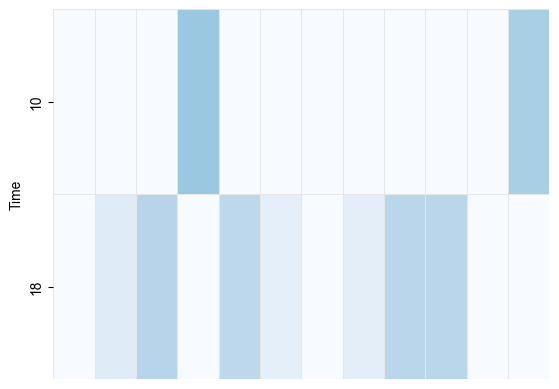

In [59]:
fig, ax = plt.subplots()
ax=plot_pert_beta_and_reference(ax, avebeta, [10,18], nonsingleton_perturbed['HF'])

# make plot

In [49]:
fontsize = 12
subfontsize = 8

In [50]:
ntime_plot = 2
notus, ncomm = thetadf.shape

In [71]:
ncomm_max = 100
notu_max = 120

tree_ratio = 0.1
gap_ratio = 0.15

In [72]:
times

[10, 18, 35, 43, 57, 65, 76]

In [73]:
ptimes = [[10,18], [35,43], [57,65]]
dnames = [['S1','HF'], ['S2', 'HFHF'], ['S3', 'LP']]

# !take subset of taxa that are in perturbed assemblages; also zero out those below threshold...!

original tree size: 1406
pruned tree size: 74


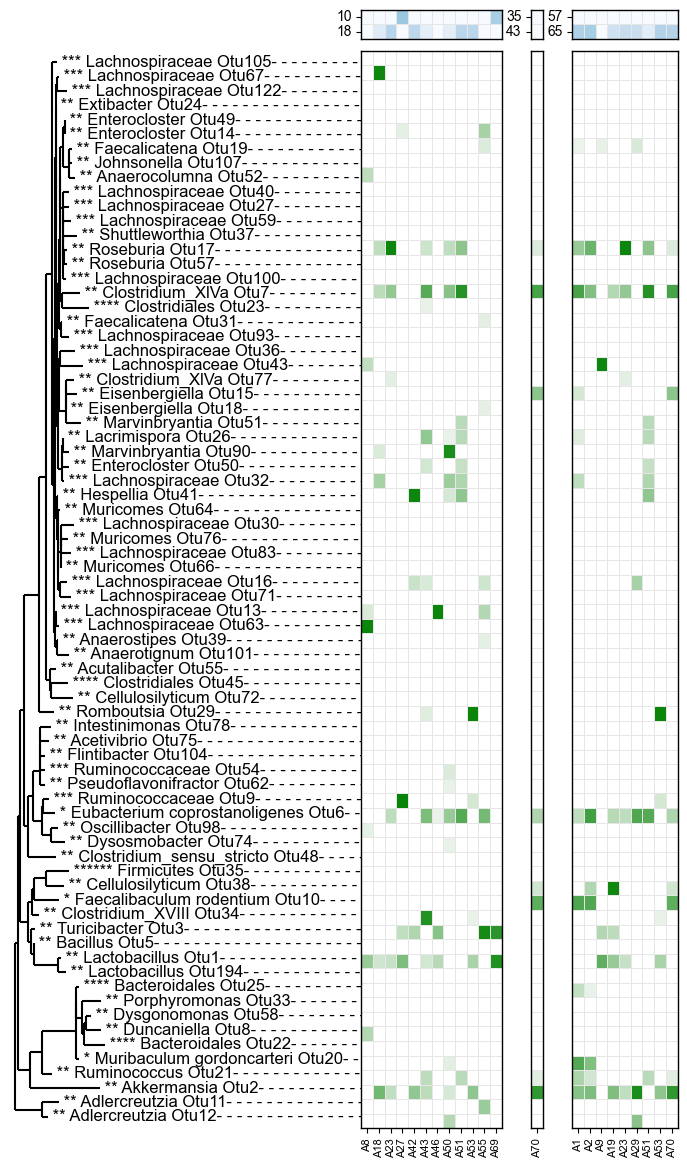

In [75]:
scale=2

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime_plot/notu_max]
hratios.append(notus/notu_max)
hratios.append(1.0 - (ntime_plot/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio]

total = tree_ratio + gap_ratio
for p in pnames:
    wid = len(nonsingleton_perturbed[p])/ncomm_max
    wratios.append(wid)
    total += wid
wratios.append(1.0 - total)

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=1+2,ncols=3 + len(pnames),
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.15,
                     hspace=0.02)

# create subplots, get axes
ax_betas = []
ax_tree = fig.add_subplot(gs[1,0])
ax_thetas = []
for i in range(len(pnames)):
    ax_betas.append(fig.add_subplot(gs[0,2+i]))
    ax_thetas.append(fig.add_subplot(gs[1,2+i]))

# plot assemblage proportions
for i,p in enumerate(pnames):
    ax_betas[i]=ax=plot_pert_beta_and_reference(ax_betas[i], avebeta, ptimes[i], nonsingleton_perturbed[p])
    ax_betas[i].set_ylabel("")
#     ax_betas[i].set_yticklabels("")
    ax_betas[i] = vis.add_border(ax_betas[i])

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
for i,p in enumerate(pnames):
    ax_thetas[i]=vis.plot_assemblages(ax_thetas[i], thetadf, otu_order, nonsingleton_perturbed[p]) #, cmap=extended_cmap, vmin=-3) #'Greens')
    ax_thetas[i].set_ylabel("")
    ax_thetas[i].set_xticklabels(ax_thetas[i].get_xticklabels(), rotation=90, fontsize=subfontsize)
    ax_thetas[i] = vis.add_border(ax_thetas[i])

In [56]:
wratios

[0.1, 0.15, 0.1, 0.008333333333333333, 0.075, 0.5666666666666667]

In [65]:
hratios

[0.016666666666666666, 0.6166666666666667, 0.3666666666666666]